# 시계열 워드 임베딩(Dynamic Bernoulli Embeddings)

In [ ]:
# %pip install git+https://github.com/llefebure/dynamic_bernoulli_embeddings.git
# pytorch+cuda 설치 필요

In [1]:
import pickle
import re 
import numpy as np
import pandas as pd

# import torch
# torch.device(0)
# from nltk import word_tokenize as nltk_word_tokenize
from gensim.corpora import Dictionary
from tqdm import tqdm
tqdm.pandas()
import regex

from kiwipiepy import Kiwi, Option
# kiwi = Kiwi()
kiwi = Kiwi(model_type='sbg') # 좀더 정확한 모델

# from mecab import MeCab
# mecab = MeCab()

from multiprocessing import cpu_count
from mpire import WorkerPool
import torch

# Gensim
import gensim
import gensim.corpora as corpora
from gensim import corpora, models
from collections import Counter
from itertools import chain

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

### 전처리

In [9]:
chosun = pd.read_parquet('./chosun_preprocessed.parquet')

In [11]:
# ~1940까지 활용
chosun = chosun[chosun['year']<=1940]

In [4]:
chosun.columns

Index(['id', 'page_no', 'regdate', 'type', 'publication_day', 'mes', 'section',
       'publication_date', 'completeness', 'news_name', 'publication_no',
       'node_id', 'source_image_file', '@timestamp', 'print_no', '@version',
       'outline', 'isn', 'isn_update', 'page_section', 'bfly_newline', 'url',
       'image', 'site', 'yonsei_merge', 'source_xml_file', 'hanja_trans_type',
       'path', 'host', 'title_archaic_hangul', 'title_archaic',
       'title_hanja_korean', 'title_korean', 'subtitle_hanja_korean',
       'subtitle_korean', 'subtitle_archaic_hangul', 'subtitle_archaic',
       'body_archaic_hangul', 'body_archaic', 'body_hanja_korean',
       'body_korean', 'authors_name', 'authors_name_hanja', 'year',
       'publisher'],
      dtype='object')

In [12]:
# 행(row) 전체수
len(chosun)

1118513

In [13]:
# 기사 종류
chosun['type'].value_counts()

article         847804
etc              56418
photo            47575
table            37078
smallad          31829
adassemblage     23627
wholead          19968
sideboxad        14595
graphic          14318
novel            12839
poem              5576
weather           4726
cartoon           1277
painting           852
handwriting         31
Name: type, dtype: int64

In [14]:
# 기사만 활용
chosun = chosun[chosun['type']=='article'].reset_index(drop=True)
chosun

,id,page_no,regdate,type,publication_day,mes,section,publication_date,completeness,news_name,...,subtitle_archaic_hangul,subtitle_archaic,body_archaic_hangul,body_archaic,body_hanja_korean,body_korean,authors_name,authors_name_hanja,year,publisher
0,119200305e1032,3,2020-03-31T13:48:20+0900,article,5,e,사회,1920-03-05,Y,cs,...,None,None,조선일보(朝鮮日報)\n창간(創刊)을축(祝)함\n후작(候爵) 대외중신(大隈重信)\n조...,朝鮮日報\n創刊을祝함\n候爵 大隈重信\n朝鮮合邦以來歲를閱한지玆에十年이되鮮人의自營하난...,조선합방이 이루어진 지 10년이 되었는데 조선인이 운영하는 신문이 없었기 때문에 지...,조선합방이 이루어진 지 10년이 되었는데 조선인이 운영하는 신문이 없었기 때문에 지...,None,None,1920,chosun
1,119200305e1034,3,2020-03-31T13:48:20+0900,article,5,e,경제,1920-03-05,Y,cs,...,None,None,조선현하(朝鮮現下)의\n공업상태(工業狀態)\n를감(鑑)하야진흥책(振興策)\n을일이(...,朝鮮現下의\n工業狀態\n를鑑하야振興策\n을一二를言함\n朝鮮의工業으로言하면從來此를賤視...,조선의 공업으로 말하면 지금까지 이를 천시만 하였을 뿐 장려는 한 적이 없어서 미미...,조선의 공업으로 말하면 지금까지 이를 천시만 하였을 뿐 장려는 한 적이 없어서 미미...,None,None,1920,chosun
2,119200305e1136,13,2020-03-30T10:07:18+0900,article,5,e,경제,1920-03-05,Y,cs,...,None,None,대정팔년조선무역개황(大正八年朝鮮貿易槪况)(일(一))\n(조선총독부재무국조사(朝鮮總督...,"大正八年朝鮮貿易槪况(一)\n(朝鮮總督府財務局調査)\n一,總况\n大正八年朝鮮貿易額은輸...",(조선총독부(朝鮮總督府) 재무국(財務局) 조사(調査))</br></br> 1. 총...,(조선총독부(朝鮮總督府) 재무국 조사)</br></br> 1. 총황</br></b...,None,None,1920,chosun
3,119200305e1137,13,2020-03-30T10:07:18+0900,article,5,e,경제,1920-03-05,Y,cs,...,None,None,두만강(豆滿江)과재목(材木)\n작년재가(昨年材價)가현저(顯著)하게고등(高騰)함은목재...,豆滿江과材木\n昨年材價가顯著하게高騰함은木材界의前途가最히多望하다하겟스나豆滿江材伐期에入...,작년(昨年) 재가(材價)가 현저(顯著)하게 고등(高騰)함은 목재계(木材界)의 전도(...,작년 재가가 현저하게 고등함은 목재계의 전도가 가장 다망하다 하겠으나 두만강 재벌기...,None,None,1920,chosun
4,119200305e1132,13,2020-03-30T10:07:17+0900,article,5,e,사회,1920-03-05,Y,cs,...,None,None,의무교육(義務敎育)은시대(時代)의요구(要求)\n우재(愚哉)\n십수년이전(十數年以前)...,義務敎育은時代의要求\n愚哉\n十數年以前은閉戶蟄居하든鎖國時代라所謂敎育이니學問이니하난것...,우재(愚哉)</br></br> 십(10) 수(數) 년(年) 이전(以前)은 폐호(閉戶...,우재</br></br> 십(10) 수 년 이전은 폐호 칩거하던 쇄국 시대라 소위 교...,愚哉,愚哉,1920,chosun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847799,692319400811e10110,1,2020-04-02T22:34:19+0900,article,7,e,사회,1940-08-11,Y,cs,...,None,None,"각계인물초치(各界人物招致)\n수상(首相),의견교환예정(意見交換豫定)\n【동경전화동맹...","各界人物招致\n首相,意見交換豫定\n【東京電話同盟】新體制確立에關하여 그根本原理組織方法...",【동경전화동맹(東京電話同盟)】 신체제확립(新體制確立)에 관(關)하여 그 근본원리조직...,【동경전화동맹】 신체제확립에 관하여 그 근본원리조직방법등에 관하여 신중고려를 한 근...,同盟,同盟,1940,chosun
847800,692319400811e10114,1,2020-04-02T22:34:19+0900,article,7,e,사회,1940-08-11,Y,cs,...,None,None,임시가족수당(臨時家族手當)\n십월(十月)부터실시결정(實施决定)\n【동경전화동맹(東京...,臨時家族手當\n十月부터實施决定\n【東京電話同盟】政府는 九日閣議에서 下級官吏에 臨時家...,【동경전화동맹(東京電話同盟)】 정부(政府)는 구일각의(九日閣議)에서 하급관리(下級官...,【동경전화동맹】 정부는 구일각의에서 하급관리에 임시가족수당지급을 결정하여 시월부터 ...,同盟,同盟,1940,chosun
847801,692319400811e10115,1,2020-04-02T22:34:19+0900,article,7,e,정치,1940-08-11,Y,cs,...,None,None,"외상(外相),수상(首相)과회담(會談)\n【동경전화동맹(東京電話同盟)】송강외상(松岡外...","外相,首相과會談\n【東京電話同盟】松岡外相은 九日定例閣議散會後 首相官邸에남어 近衞首相...",【동경전화동맹(東京電話同盟)】 송강외상(松岡外相)은 구일정례각의산회후(九日定例閣議散...,【동경전화동맹】 송강외상은 구일정례각의산회후 수상 관저에남아 근위수상과 회견하고 당...,同盟,同盟,1940,chosun
847802,692319400811e10118,1,2020-04-02T22:34:20+0900,article,7,e,사회,1940-08-11,Y,cs,...,None,None,인사(人事)·집회(集會)\n▲주(朱)□의씨(宜氏)(전보성중학교장(前普成中學校長))퇴...,人事·集會\n▲朱□宜氏(前普成中學校長)退任人事次十日來社\n▲鈴木文次郞氏(全朝鮮洋服商...,▲ 주(朱)□ 의씨(宜氏)(전보성중학교장(前普成中學校長)) 퇴임인사차십일내사(退任人...,▲ 주□ 의씨(전보성중학교장(前普成中學校長)) 퇴임인사차십일내사</br></br> ...,None,None,1940,chosun


In [15]:
# 현대어 존재하는 기사만 활용
chosun = chosun.dropna(subset=['body_korean']).reset_index(drop=True)
chosun

,id,page_no,regdate,type,publication_day,mes,section,publication_date,completeness,news_name,...,subtitle_archaic_hangul,subtitle_archaic,body_archaic_hangul,body_archaic,body_hanja_korean,body_korean,authors_name,authors_name_hanja,year,publisher
0,119200305e1032,3,2020-03-31T13:48:20+0900,article,5,e,사회,1920-03-05,Y,cs,...,None,None,조선일보(朝鮮日報)\n창간(創刊)을축(祝)함\n후작(候爵) 대외중신(大隈重信)\n조...,朝鮮日報\n創刊을祝함\n候爵 大隈重信\n朝鮮合邦以來歲를閱한지玆에十年이되鮮人의自營하난...,조선합방이 이루어진 지 10년이 되었는데 조선인이 운영하는 신문이 없었기 때문에 지...,조선합방이 이루어진 지 10년이 되었는데 조선인이 운영하는 신문이 없었기 때문에 지...,None,None,1920,chosun
1,119200305e1034,3,2020-03-31T13:48:20+0900,article,5,e,경제,1920-03-05,Y,cs,...,None,None,조선현하(朝鮮現下)의\n공업상태(工業狀態)\n를감(鑑)하야진흥책(振興策)\n을일이(...,朝鮮現下의\n工業狀態\n를鑑하야振興策\n을一二를言함\n朝鮮의工業으로言하면從來此를賤視...,조선의 공업으로 말하면 지금까지 이를 천시만 하였을 뿐 장려는 한 적이 없어서 미미...,조선의 공업으로 말하면 지금까지 이를 천시만 하였을 뿐 장려는 한 적이 없어서 미미...,None,None,1920,chosun
2,119200305e1136,13,2020-03-30T10:07:18+0900,article,5,e,경제,1920-03-05,Y,cs,...,None,None,대정팔년조선무역개황(大正八年朝鮮貿易槪况)(일(一))\n(조선총독부재무국조사(朝鮮總督...,"大正八年朝鮮貿易槪况(一)\n(朝鮮總督府財務局調査)\n一,總况\n大正八年朝鮮貿易額은輸...",(조선총독부(朝鮮總督府) 재무국(財務局) 조사(調査))</br></br> 1. 총...,(조선총독부(朝鮮總督府) 재무국 조사)</br></br> 1. 총황</br></b...,None,None,1920,chosun
3,119200305e1137,13,2020-03-30T10:07:18+0900,article,5,e,경제,1920-03-05,Y,cs,...,None,None,두만강(豆滿江)과재목(材木)\n작년재가(昨年材價)가현저(顯著)하게고등(高騰)함은목재...,豆滿江과材木\n昨年材價가顯著하게高騰함은木材界의前途가最히多望하다하겟스나豆滿江材伐期에入...,작년(昨年) 재가(材價)가 현저(顯著)하게 고등(高騰)함은 목재계(木材界)의 전도(...,작년 재가가 현저하게 고등함은 목재계의 전도가 가장 다망하다 하겠으나 두만강 재벌기...,None,None,1920,chosun
4,119200305e1132,13,2020-03-30T10:07:17+0900,article,5,e,사회,1920-03-05,Y,cs,...,None,None,의무교육(義務敎育)은시대(時代)의요구(要求)\n우재(愚哉)\n십수년이전(十數年以前)...,義務敎育은時代의要求\n愚哉\n十數年以前은閉戶蟄居하든鎖國時代라所謂敎育이니學問이니하난것...,우재(愚哉)</br></br> 십(10) 수(數) 년(年) 이전(以前)은 폐호(閉戶...,우재</br></br> 십(10) 수 년 이전은 폐호 칩거하던 쇄국 시대라 소위 교...,愚哉,愚哉,1920,chosun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844246,692319400811e10110,1,2020-04-02T22:34:19+0900,article,7,e,사회,1940-08-11,Y,cs,...,None,None,"각계인물초치(各界人物招致)\n수상(首相),의견교환예정(意見交換豫定)\n【동경전화동맹...","各界人物招致\n首相,意見交換豫定\n【東京電話同盟】新體制確立에關하여 그根本原理組織方法...",【동경전화동맹(東京電話同盟)】 신체제확립(新體制確立)에 관(關)하여 그 근본원리조직...,【동경전화동맹】 신체제확립에 관하여 그 근본원리조직방법등에 관하여 신중고려를 한 근...,同盟,同盟,1940,chosun
844247,692319400811e10114,1,2020-04-02T22:34:19+0900,article,7,e,사회,1940-08-11,Y,cs,...,None,None,임시가족수당(臨時家族手當)\n십월(十月)부터실시결정(實施决定)\n【동경전화동맹(東京...,臨時家族手當\n十月부터實施决定\n【東京電話同盟】政府는 九日閣議에서 下級官吏에 臨時家...,【동경전화동맹(東京電話同盟)】 정부(政府)는 구일각의(九日閣議)에서 하급관리(下級官...,【동경전화동맹】 정부는 구일각의에서 하급관리에 임시가족수당지급을 결정하여 시월부터 ...,同盟,同盟,1940,chosun
844248,692319400811e10115,1,2020-04-02T22:34:19+0900,article,7,e,정치,1940-08-11,Y,cs,...,None,None,"외상(外相),수상(首相)과회담(會談)\n【동경전화동맹(東京電話同盟)】송강외상(松岡外...","外相,首相과會談\n【東京電話同盟】松岡外相은 九日定例閣議散會後 首相官邸에남어 近衞首相...",【동경전화동맹(東京電話同盟)】 송강외상(松岡外相)은 구일정례각의산회후(九日定例閣議散...,【동경전화동맹】 송강외상은 구일정례각의산회후 수상 관저에남아 근위수상과 회견하고 당...,同盟,同盟,1940,chosun
844249,692319400811e10118,1,2020-04-02T22:34:20+0900,article,7,e,사회,1940-08-11,Y,cs,...,None,None,인사(人事)·집회(集會)\n▲주(朱)□의씨(宜氏)(전보성중학교장(前普成中學校長))퇴...,人事·集會\n▲朱□宜氏(前普成中學校長)退任人事次十日來社\n▲鈴木文次郞氏(全朝鮮洋服商...,▲ 주(朱)□ 의씨(宜氏)(전보성중학교장(前普成中學校長)) 퇴임인사차십일내사(退任人...,▲ 주□ 의씨(전보성중학교장(前普成中學校長)) 퇴임인사차십일내사</br></br> ...,None,None,1940,chosun


<AxesSubplot: >

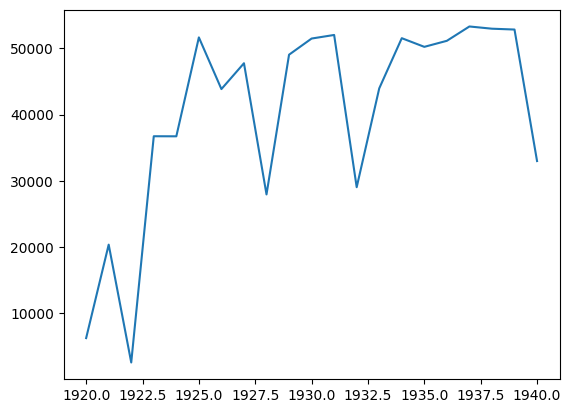

In [16]:
chosun['year'].value_counts().sort_index().plot()

In [ ]:
# br 태그 삭제
chosun['body_korean'] = chosun['body_korean'].str.replace('</br>','')

In [ ]:
# 【三十日東京特電】 처럼 특파원 삭제
chosun['body_korean'] = chosun['body_korean'].str.replace('\【.+\】','',regex=True)

In [12]:
# hanja
# hanja = regex.compile('\p{Han}+')

In [14]:
## 토크나이징 함수 선언
def tokenize(sent):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    return [word + ('다' if tag.startswith('V') else '') # 동사/형용사에는 '다'를 붙여줌
            for word, tag, _, _ in res
            if not tag.startswith('E') and not tag.startswith('J') and not tag.startswith('S') and not tag.startswith('UN') and not tag.startswith('VCP')] # 조사, 어미, 특수기호, 분석불가, 긍정보조사 삭제

In [ ]:
# 토크나이징(멀티프로세싱)
with WorkerPool(n_jobs=cpu_count()-1) as pool:
    results = pool.map(tokenize, chosun['body_korean'].tolist(),progress_bar=True)

In [31]:
# with open('./variables/chosun_token.pkl','wb') as f:
#     pickle.dump(results,f)
with open('./variables/chosun_token.pkl','rb') as f:
    results = pickle.load(f)

In [32]:
# 상위 n개 Unigram 확인
tokens = chain(*results)
cnt = Counter(tokens)
topn_list = cnt.most_common(1000) # 상위 N개

In [34]:
results

[['조선',
  '합방',
  '이루어지다',
  '지',
  '년',
  '되다',
  '데',
  '조선',
  '인',
  '운영',
  '하',
  '신문',
  '없다',
  '때문',
  '지난겨울',
  '일',
  '같다',
  '불상사',
  '일어나다',
  '그러나',
  '서양',
  '수시로',
  '조선',
  '티베트',
  '알다',
  '못하다',
  '곳',
  '생각',
  '하',
  '일본',
  '제국',
  '조선',
  '통치',
  '정책',
  '오해',
  '하',
  '멈추다',
  '않다',
  '이것',
  '주로',
  '역대',
  '총독',
  '신문',
  '이용',
  '하',
  '일본',
  '조선',
  '합방',
  '진정',
  '하',
  '모습',
  '모든',
  '조선인',
  '철저',
  '하',
  '알리다',
  '못',
  '하',
  '조선인',
  '들',
  '조선',
  '통치',
  '근본',
  '방침',
  '철저히',
  '알다',
  '못',
  '하다',
  '암중모색',
  '하',
  '형편',
  '벗어나다',
  '못',
  '하',
  '때때로',
  '동요',
  '하',
  '것',
  '그러나',
  '이제',
  '예종석',
  '씨',
  '의하다',
  '조선일보',
  '발간',
  '보다',
  '이르다',
  '것',
  '지극히',
  '기쁘다',
  '일',
  '이제',
  '일본',
  '제국',
  '조선',
  '통치',
  '방침',
  '잘',
  '이해',
  '시키',
  '일본',
  '조선',
  '두',
  '민족',
  '하나',
  '만들다',
  '공고하다',
  '단결',
  '위하다',
  '나가다',
  '않다',
  '두',
  '민족',
  '앞날',
  '기대',
  '하',
  '어렵다',
  '생각',
  '하',
  '지식인',
  '조선',
  '어',
  '조선인',
  '위하다',

In [33]:
topn_df = pd.DataFrame(topn_list)
topn_df.columns =['term','freq']
topn_df

,term,freq
0,하,7132387
1,하다,2014813
2,일,1950241
3,것,1435734
4,있다,1217854
...,...,...
995,세우다,16701
996,질문,16691
997,입학,16677
998,교장,16665


In [ ]:
# [w for w in topn_list if w[0].split('/')[1].startswith('NNP') or w[0].split('/')[1].startswith('NNG')]

In [ ]:
# stopwords = set(['이다','하다','하다','위하다','되다','있다','없다','않다','아니다','하'])

In [ ]:
chosun['bow'] = pd.Series(results)
# donga['bow'] = pd.Series(results)

In [24]:
chosun['bow']

0         [조선, 합방, 이루어지다, 지, 년, 되다, 데, 조선, 인, 운영, 하, 신문,...
1         [조선, 공업, 말, 하, 지금, 이, 천시, 하다, 뿐, 장려, 한, 적, 없다,...
2         [조선총독부, 재무, 국, 조사, 총, 황, 대정, 년, 조선, 무역, 액, 수, ...
3         [작년, 재가, 현저, 하, 고등, 하, 목재, 계, 전도, 가장, 다, 망하다, ...
4         [우재, 십, 수, 년, 이전, 폐호, 칩거, 하, 쇄국, 시대, 소위, 교육, 학...
                                ...                        
844246    [신, 체제, 확립, 관하다, 그, 근본, 원리, 조직, 방법, 등, 관하다, 신중...
844247    [정부, 구, 일, 각의, 하급, 관리, 임시, 가족, 수당, 지급, 결정, 하, ...
844248    [송강, 외상, 구, 일, 정례, 각의, 산, 회, 후, 수상, 관저, 남아, 근위...
844249    [주, 의씨, 전, 보성중학교, 장, 퇴임, 인사, 차, 십, 일, 내사, 영목, ...
844250    [중지, 함대, 보도, 부, 월, 구, 일, 오후, 사시, 발표, 강상, 함대, 일...
Name: bow, Length: 844251, dtype: object

In [ ]:
chosun['time'] = chosun['year'] - chosun['year'].min()
chosun['time'] = chosun['time'].astype(int)

In [ ]:
# donga['time'] = donga['year'] - donga['year'].min()
# donga['time'] = donga['time'].astype(int)

In [ ]:
dataset = chosun[['bow','time','year']]
# dataset = donga[['bow','time','year']]
dataset

,bow,time,year
0,"[조선, 합방, 이루어지다, 지, 년, 되다, 데, 조선, 인, 운영, 하, 신문,...",0,1920
1,"[조선, 공업, 말, 하, 지금, 이, 천시, 하다, 뿐, 장려, 한, 적, 없다,...",0,1920
2,"[조선총독부, 재무, 국, 조사, 총, 황, 대정, 년, 조선, 무역, 액, 수, ...",0,1920
3,"[작년, 재가, 현저, 하, 고등, 하, 목재, 계, 전도, 가장, 다, 망하다, ...",0,1920
4,"[우재, 십, 수, 년, 이전, 폐호, 칩거, 하, 쇄국, 시대, 소위, 교육, 학...",0,1920
...,...,...,...
844246,"[신, 체제, 확립, 관하다, 그, 근본, 원리, 조직, 방법, 등, 관하다, 신중...",20,1940
844247,"[정부, 구, 일, 각의, 하급, 관리, 임시, 가족, 수당, 지급, 결정, 하, ...",20,1940
844248,"[송강, 외상, 구, 일, 정례, 각의, 산, 회, 후, 수상, 관저, 남아, 근위...",20,1940
844249,"[주, 의씨, 전, 보성중학교, 장, 퇴임, 인사, 차, 십, 일, 내사, 영목, ...",20,1940


In [27]:
dataset.to_pickle('./230221_chosun_dataset.pkl')

### DBE 학습

In [12]:
import pandas as pd
# import os
import torch
import pickle
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]= "1,2,3"
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:24560'

from dynamic_bernoulli_embeddings.analysis import DynamicEmbeddingAnalysis
from dynamic_bernoulli_embeddings.training import train_model

from gensim.corpora import Dictionary

In [5]:
# dataset = pd.read_parquet('./chosun_donga_dataset.parquet')
dataset = pd.read_pickle('./230221_chosun_dataset.pkl')

In [ ]:
# 토큰 10개 이상 쓴 기사만 필터링
# dataset = dataset[dataset['bow'].str.len()>=10].reset_index(drop=True)

In [ ]:
# chosun
# dataset = dataset[dataset['publisher']=='chosun'].reset_index(drop=True)

In [ ]:
# 동아일보
# dataset = dataset[dataset['publisher']=='donga'].reset_index(drop=True)
# dataset

In [31]:
dictionary = Dictionary(dataset.bow)
print(len(dictionary))
dictionary.filter_extremes(no_below=1000, no_above=0.9)
dictionary.compactify()
print(len(dictionary))

1268236
7625


In [32]:
dataset = dataset[['bow','time']]

In [6]:
# dictionary.save('./chosun_1000_dictionary')
# dictionary.save('./donga_2000_dictionary')
dictionary = Dictionary.load('./chosun_1000_dictionary')
# dictionary = Dictionary.load('./chosun_donga_5000_dictionary')

In [7]:
# dataset 저장(df + dictionary)
# dataset_ddp = {}
# dataset_ddp['dataset'] = dataset
# dataset_ddp['dictionary'] = dictionary
# with open('/home/bjkim/dynamic_bernoulli_embeddings/data/data.pkl', 'wb') as f:
#     pickle.dump(dataset_ddp, f, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# with open('/home/bjkim/dynamic_bernoulli_embeddings/checkpoint/emb.pkl', 'rb') as f:
#     emb = pickle.load(f)

In [7]:
model, loss_history = train_model(
    dataset, dictionary.token2id, validation=.1, num_epochs=10, k=100, notebook=True)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [8]:
# torch.save(model,'./230128_donga_DBE.pt')
torch.save(model,'./230222_chosun_DBE.pt')
# model = torch.load('./230128_chosun_DBE.pt')
# model = torch.load('/home/bjkim/dynamic_bernoulli_embeddings/checkpoint/model.pt')

In [18]:
emb = DynamicEmbeddingAnalysis(model.get_embeddings(), dictionary.token2id)

In [19]:
emb.absolute_drift(n=999)

[(1.0714741, '소화'),
 (0.9883522, '지나가다'),
 (0.9448322, '인민'),
 (0.9146531, '독립'),
 (0.9067365, '강연'),
 (0.8960386, '총통'),
 (0.8941329, '가치'),
 (0.88998586, '강화'),
 (0.88416785, '사변'),
 (0.8583762, '동경'),
 (0.8443086, '디'),
 (0.8412359, '공판'),
 (0.83377826, '북경'),
 (0.82095426, '단연'),
 (0.8183429, '전보'),
 (0.81424254, '통제'),
 (0.8141995, '청년회'),
 (0.81089747, '사진'),
 (0.806053, '만주국'),
 (0.8033389, '인식'),
 (0.80306625, '런던'),
 (0.8003768, '시국'),
 (0.7972625, '불성'),
 (0.79161084, '대정'),
 (0.7843118, '중경'),
 (0.77932024, '고로'),
 (0.77491814, '정권'),
 (0.76525444, '번지'),
 (0.7646384, '연맹'),
 (0.76406145, '장작'),
 (0.7607156, '동맹'),
 (0.758311, '소련'),
 (0.75260377, '기구'),
 (0.75130045, '방송'),
 (0.74609166, '뉴스'),
 (0.7439206, '주목'),
 (0.7425589, '지국'),
 (0.73798144, '무산'),
 (0.7374207, '배급'),
 (0.73329544, '주간'),
 (0.7296344, '신경'),
 (0.72918767, '러시아'),
 (0.72663057, '조정'),
 (0.72475266, '기근'),
 (0.7191092, '노농'),
 (0.7156008, '동아'),
 (0.71199894, '조선일보사'),
 (0.71011144, '재계'),
 (0.70959365,

In [20]:
over_time = {}
for i in range(0, dataset.time.max() + 1, 1):
    col = str(dataset.year.min() + i)
    over_time[col] = emb.neighborhood("독립", i, 20)
pd.DataFrame(over_time)

,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,...,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940
0,단원,대한,대한,대한,대한,자치,자치,자치,자치,자치,...,자치,자치,자치,분립,분립,분립,분립,분립,분립,분립
1,운동,단원,단원,단,자치,대한,선포,선포,선포,선포,...,선포,분립,분립,자치,공화국,결합,공화국,평등,평등,평등
2,대한,군자금,공산주의,단원,선포,건국,건국,건국,주체,주체,...,분립,선포,선포,공화국,병합,합병,평등,공화국,공화국,공화국
3,공산주의,운동,군자금,자치,무장,선포,병합,공화국,공화국,공화국,...,공화국,공화국,공화국,병합,합병,병합,합병,사회주의,합병,민족
4,군자금,공산주의,수령,무장,공산주의,공산주의,대한,주체,건국,건국,...,주체,건국,병합,선포,자치,공화국,결합,결합,사회주의,사회주의
5,수령,단,자치,군자금,건국,병합,공화국,병합,병합,분립,...,건국,주체,합병,합병,선포,선포,병합,협약,결합,결합
6,당원,당원,공산당원,수령,수령,애국,주체,분립,해방,병합,...,병합,병합,주체,결합,결합,평등,선포,복귀,복귀,합병
7,단,공산당원,당원,공산주의,단,주체,공산주의,합작,분립,합작,...,합작,해방,해방,해방,해방,해방,사회주의,합병,민족,병합
8,공산당원,수령,단,모종,모종,공화국,해방,해방,합작,해방,...,해방,합병,협약,주체,권력,존속,터키,터키,병합,협약
9,애국,모종,무장,공산당원,단원,무장,합작,결합,국가,복건,...,복건,주권,주권,존속,사회주의,기반,협약,민족,협약,주권


In [21]:
over_time = {}
for i in range(0, dataset.time.max() + 1, 1):
    col = str(dataset.year.min() + i)
    over_time[col] = emb.neighborhood("민족", i, 20)
pd.DataFrame(over_time)

,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,...,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940
0,문화,문화,민중,민중,민중,민중,민중,인종,민중,민중,...,문화,문화,문화,문화,문화,문화,문화,인종,인종,인종
1,민중,민중,문화,문화,인종,인종,인종,민중,인류,인류,...,인종,인류,인종,인종,인종,인종,인종,문화,문화,문화
2,인류,멸망,인류,인류,인류,인류,인류,인류,인종,인종,...,인류,인종,인류,인류,인류,인류,인류,멸망,멸망,인류
3,멸망,인종,우리,우리,국가,국가,해방,문화,문화,문화,...,민중,민중,민중,민중,민중,멸망,멸망,인류,인류,멸망
4,우리,인류,인종,인종,문화,문화,제국주의,제국주의,해방,해방,...,무릇,무릇,무릇,무릇,무릇,민중,제국주의,제국주의,제국주의,제국주의
5,국민,우리,멸망,멸망,멸망,제국주의,국가,우리,제국주의,제국주의,...,의식,문학,멸망,멸망,멸망,무릇,사회주의,나라,나라,결합
6,인종,국민,국민,국가,우리,우리,문화,국가,국가,의식,...,제국주의,멸망,언어,문학,문학,제국주의,투쟁,투쟁,투쟁,사회주의
7,참되다,국가,국가,제국주의,제국주의,멸망,우리,해방,멸망,국가,...,멸망,제국주의,문학,언어,국가,국가,무릇,사회주의,사회주의,나라
8,국가,참되다,참되다,국민,국민,국민,멸망,멸망,의식,무릇,...,문학,의식,제국주의,제국주의,제국주의,결합,결합,무릇,결합,투쟁
9,동포,동포,오늘날,참되다,해방,해방,국민,침략,무릇,멸망,...,국가,언어,결합,나라,오늘날,나라,나라,결합,무릇,무릇


In [22]:
over_time = {}
for i in range(0, dataset.time.max() + 1, 1):
    col = str(dataset.year.min() + i)
    over_time[col] = emb.neighborhood("조선", i, 20)
pd.DataFrame(over_time)

,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,...,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940
0,외지,외지,대만,대만,대만,일본,외지,대만,외지,대만,...,반도,대만,대만,반도,반도,반도,반도,반도,반도,반도
1,대만,대만,외지,외지,외지,외지,대만,외지,대만,외지,...,대만,반도,외지,대만,대만,일본,대만,일본,일본,일본
2,일본,일본,일본,일본,일본,대만,일본,일본,일본,반도,...,조서,외지,반도,외지,일본,대만,외지,대만,대만,대만
3,만주,만주,북조선,북조선,북조선,북조선,반도,반도,반도,일본,...,외지,조서,일본,일본,외지,외지,일본,외지,외지,남조선
4,해외,북조선,만주,만주,해외,해외,북조선,북조선,북조선,조서,...,일본,북선,총독부,북선,북선,북선,남조선,남조선,조선총독부,외지
5,북조선,해외,해외,해외,만주,외국,외국,조서,조서,북조선,...,북조선,일본,북선,조선인,조선인,남조선,북조선,총독부,총독부,총독부
6,장려,장려,남조선,남조선,남조선,반도,해외,만주,해외,남조선,...,남조선,남조선,남조선,총독부,남조선,조선인,총독부,조선인,남조선,조선인
7,북선,북선,북선,북선,외국,만주,만주,외국,만주,북선,...,북선,북조선,조서,남조선,북조선,북조선,북선,북조선,관동,북조선
8,외국,반도,반도,반도,반도,남조선,남조선,북선,외국,간도,...,간도,간도,조선인,북조선,총독부,총독부,조선총독부,조선총독부,조선인,조선총독부
9,간도,간도,외국,장려,북선,북선,북선,해외,북선,만주,...,조선총독부,조선총독부,북조선,조서,본도,본도,조선인,북선,북조선,북선


In [23]:
over_time = {}
for i in range(0, dataset.time.max() + 1, 1):
    col = str(dataset.year.min() + i)
    over_time[col] = emb.neighborhood("일본", i, 20)
pd.DataFrame(over_time)

,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,...,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940
0,중국,중국,중국,중국,중국,중국,중국,대만,대만,대만,...,중국,중국,중국,미국,중국,중국,미국,중국,중국,중국
1,미국,미국,대만,대만,대만,대만,대만,중국,중국,미국,...,대만,대만,미국,중국,미국,미국,중국,미국,미국,미국
2,대만,대만,미국,미국,미국,미국,미국,미국,미국,중국,...,미국,미국,영국,영국,영국,영국,동양,영국,일본인,일본인
3,외국,지나,지나,북해도,외국,외국,외국,외국,외국,외국,...,만주국,만주국,대만,외국,대만,외국,영국,제국,영국,동양
4,지나,외국,외국,지나,지나,지나,지나,동양,지나,지나,...,소련,소련,외국,각국,지나,대일,대만,일본인,제국,제국
5,동양,외지,북해도,조선,조선,조선,동양,지나,동양,만주국,...,외국,영국,소련,대만,대일,조선,대일,동양,동양,대일
6,외지,만주국,조선,외국,북해도,동양,북해도,만주국,만주국,동양,...,영국,이태리,이태리,영미,조선,지나,조선,제네바,대일,소연방
7,만주국,영국,외지,고베,외지,북해도,조선,영국,만주,캐나다,...,이태리,소연방,지나,지나,외국,대만,일본인,소연방,소연방,제네바
8,만몽,만몽,고베,외지,만주국,캐나다,캐나다,캐나다,영국,만주,...,소연방,지나,만주,대일,동양,각국,제국,대일,제네바,영국
9,영국,만주,만주국,교토,만주,극동,외지,북해도,캐나다,영국,...,만주,만주,만주국,타국,각국,소련,외국,만몽,일화,대만


In [24]:
over_time = {}
for i in range(0, dataset.time.max() + 1, 1):
    col = str(dataset.year.min() + i)
    over_time[col] = emb.neighborhood("문화", i, 20)
pd.DataFrame(over_time)

,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,...,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940
0,문명,문명,문명,문명,문명,문명,문명,문명,문명,문명,...,문명,문명,민족,민족,민족,민족,예술,예술,예술,예술
1,민족,민족,민족,계발,계발,계발,근대,근대,근대,현대,...,민족,민족,문명,문명,예술,예술,민족,민족,민족,민족
2,계발,민중,민중,정치,정치,근대,계발,현대,현대,근대,...,현대,현대,예술,예술,문명,문명,문명,문명,문명,문명
3,민중,계발,계발,민족,민족,민족,현대,계발,계발,민족,...,근대,근대,현대,현대,현대,현대,현대,현대,인류,과학
4,정치,정치,정치,민중,근대,정치,선진,민족,선진,원시,...,예술,예술,근대,근대,인류,인류,인류,인류,현대,문학
5,근대,근대,근대,향상,민중,현대,원시,원시,민족,계발,...,계발,계발,인류,인류,계발,과학,과학,과학,과학,현대
6,개발,향상,향상,근대,현대,민중,민족,선진,원시,선진,...,인류,과학,과학,문학,문학,계발,문학,문학,문학,인류
7,향상,개발,현대,현대,향상,원시,문학,정치,인류,민중,...,과학,인류,민중,계발,근대,문학,근대,근대,근대,근대
8,현대,과학,개발,개발,개발,선진,예술,인류,정치,인류,...,선진,찬란,문학,과학,과학,학문,종교,종교,정치,문예
9,과학,현대,과학,과학,원시,문학,정치,찬란,민중,찬란,...,종교,문학,계발,민중,찬란,근대,학문,계발,찬란,영역
